<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/ECG_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

TPU has a different way of downloading dependencies keep the cell below to avoid dependency conflicts

In [3]:
!pip install -qqqq mlflow wfdb resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.

In [4]:
import mlflow
import wfdb
import resampy

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

import argparse
import pandas as pd
import numpy as np
from pathlib import Path
import wfdb
from tqdm.auto import tqdm
from extract_headers import extract_and_open_files_in_zip

In [6]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

# from icdmappings import Mapper
from ecg_utils import prepare_mimicecg
from mimic_ecg_preprocessing import prepare_mimic_ecg

In [7]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src/utils')

# from timeseries_utils import reformat_as_memmap
from stratify import stratified_subsets

In [8]:
memmap_meta_path = "src/data/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_mapped_path = "src/data/records_w_stroke_labels.csv"
df_pkl_path = "src/data/processed/df.pkl"

In [14]:
import pandas as pd
import numpy as np

# Load the memmap metadata
memmap_meta = np.load("src/data/memmap_meta.npz")
# memmap_meta.files will give you the keys, e.g., ['study_id', 'ecg_time']
# To access data for a specific key, use memmap_meta['key']
print(memmap_meta.files)

['start', 'length', 'shape', 'dtype']


In [20]:
# Load the memmap data with memory-mapping
memmap_data = np.fromfile("src/data/memmap/memmap.npy", dtype=np.float32)

# Access a small slice of the data
preview_data = memmap_data[:10]  # Get the first 10 rows

# Print the preview data
print(preview_data)

[ 0.00298791 -0.14767101  0.07639093  0.11540098  0.14979135  0.14231178
  0.13482904  0.1541257  -0.15273552  0.06428077]


Original shape from metadata: (np.int64(21649000), np.int64(12))
Number of individual recordings: 21649
Reshaped ECG data: (21649000, 12)


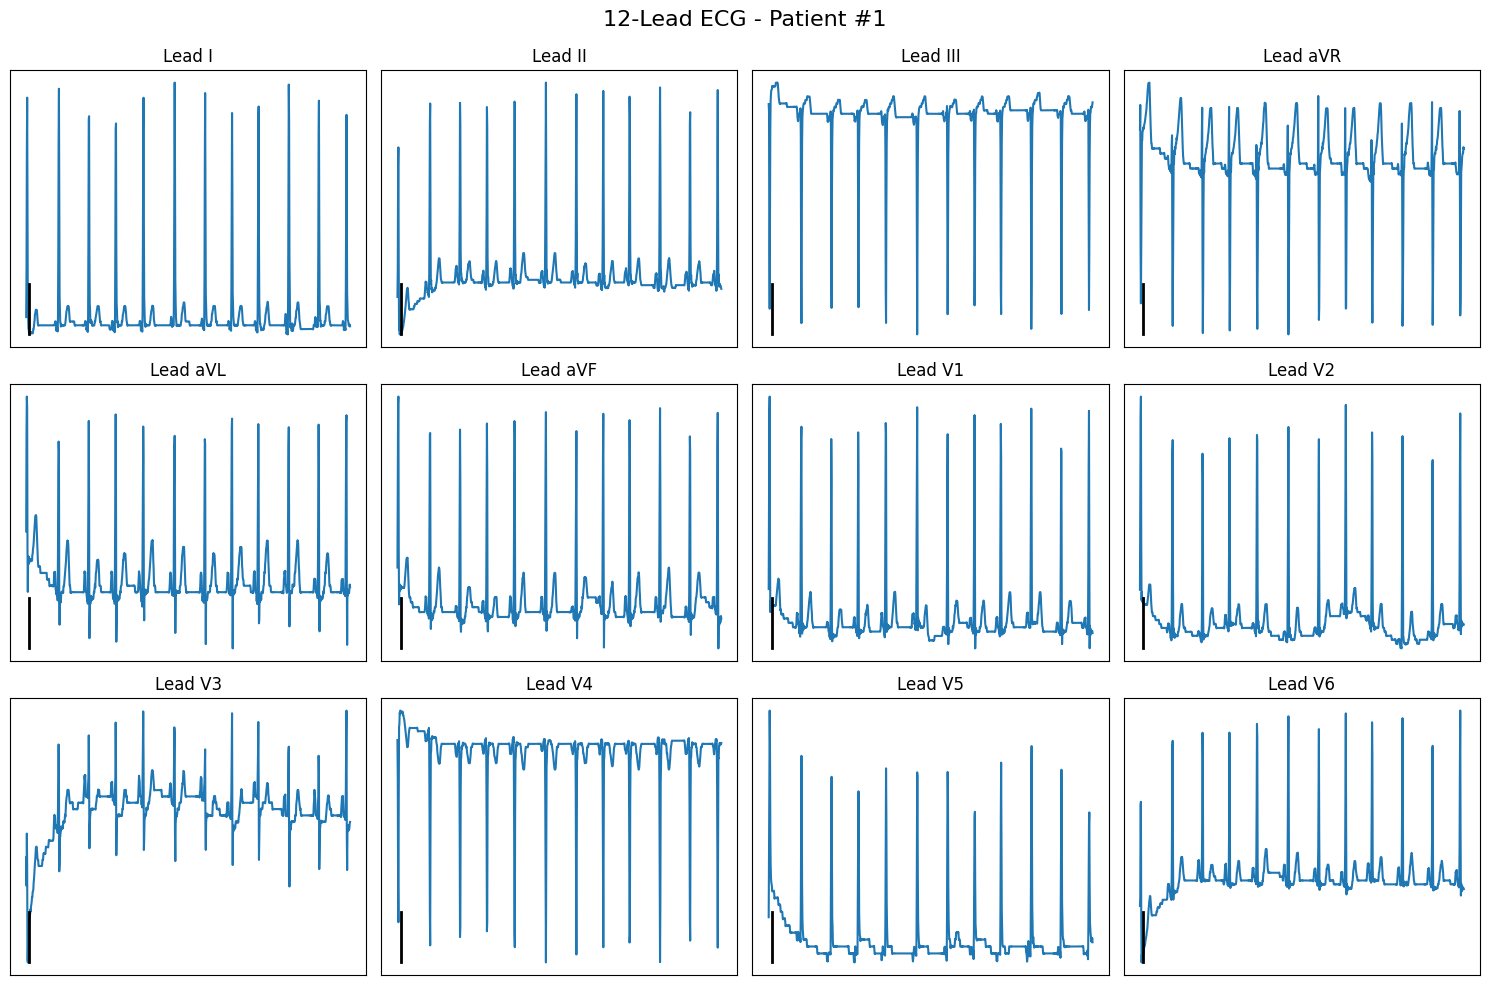

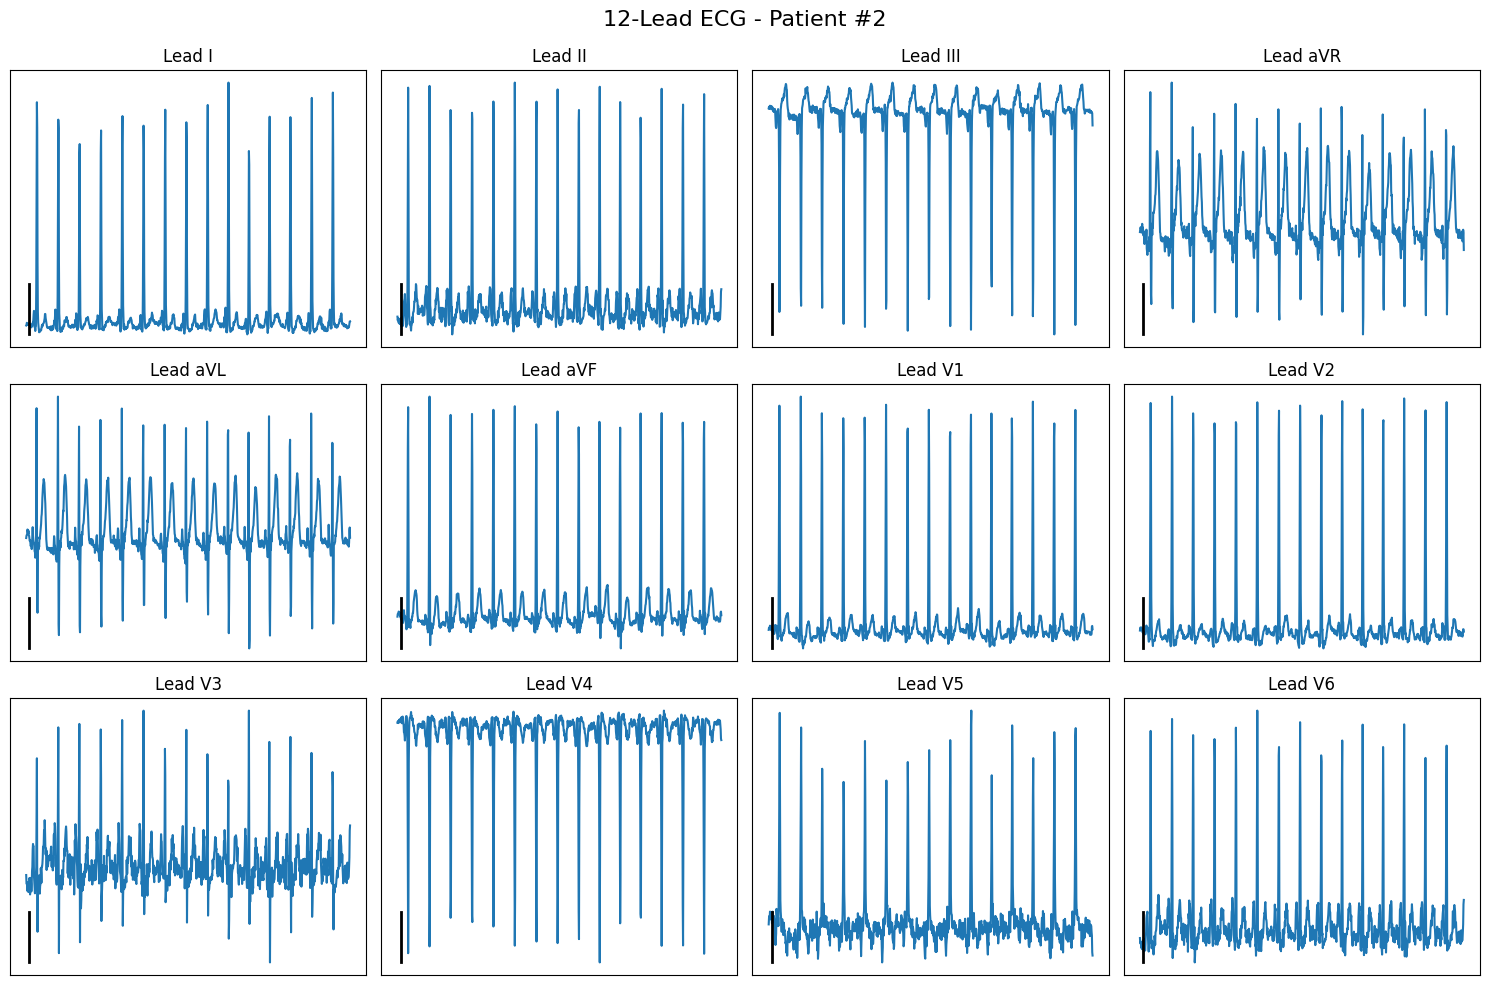

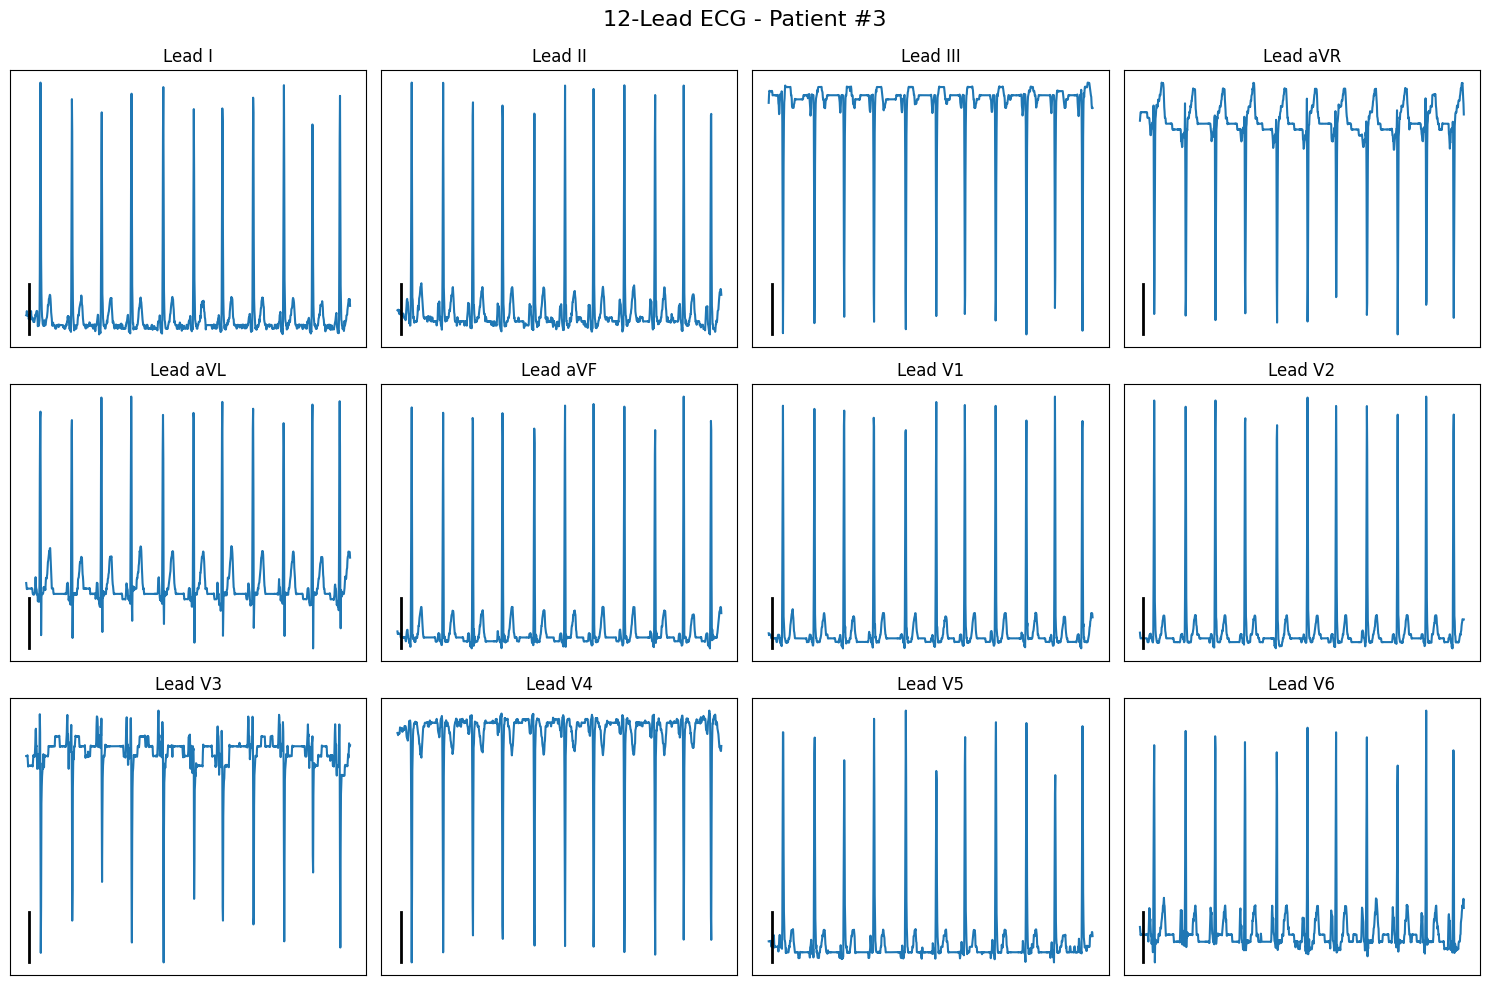


Statistics for all ECG data:
Min value: nan
Max value: nan
Mean: nan
Standard deviation: nan


In [21]:
import numpy as np
import matplotlib.pyplot as plt

starts = memmap_meta["start"]
lengths = memmap_meta["length"]
original_shape = tuple(memmap_meta["shape"])
print(f"Original shape from metadata: {original_shape}")
print(f"Number of individual recordings: {len(starts)}")

# Reshape data according to metadata
ecg_data = memmap_data.reshape(original_shape)
print(f"Reshaped ECG data: {ecg_data.shape}")

# Function to visualize a 12-lead ECG
def visualize_12lead_ecg(ecg_data, patient_index=0):
    # Get the start and length for this patient
    start_idx = starts[patient_index]
    length = lengths[patient_index]

    # Extract the data for this patient - all 12 leads
    patient_data = ecg_data[start_idx:start_idx+length, :]

    # Standard 12-lead ECG lead names
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Create a figure with 12 subplots (3x4 grid)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each lead
    for i, ax in enumerate(axes):
        if i < 12:  # We have 12 leads
            ax.plot(patient_data[:, i])
            ax.set_title(f'Lead {lead_names[i]}')
            ax.grid(True, alpha=0.3)

            # Add a small vertical scale bar (1 mV)
            # This is an approximation - normally would need calibration
            y_range = np.max(patient_data[:, i]) - np.min(patient_data[:, i])
            scale_bar = y_range * 0.2  # 20% of the range as a scale reference
            ax.plot([10, 10], [np.min(patient_data[:, i]), np.min(patient_data[:, i]) + scale_bar],
                   'k-', linewidth=2)

            # Remove tick labels to mimic clinical ECG appearance
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')  # Hide unused subplot

    # Add a title for the entire plot
    plt.suptitle(f'12-Lead ECG - Patient #{patient_index+1}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle

    return fig

# Visualize ECGs for first 3 patients
for i in range(3):
    fig = visualize_12lead_ecg(ecg_data, i)
    plt.figure(fig.number)
    plt.savefig(f'patient_{i+1}_12lead_ecg.png', dpi=300, bbox_inches='tight')
    plt.show()

# Basic statistics
print("\nStatistics for all ECG data:")
print("Min value:", ecg_data.min())
print("Max value:", ecg_data.max())
print("Mean:", ecg_data.mean())
print("Standard deviation:", ecg_data.std())

In [ ]:
# Load the CSV file
df_mapped = pd.read_csv("src/data/records_w_stroke_labels.csv")
print("Columns in df_mapped:", df_mapped.columns)
# To see the first few rows, run: df_mapped.head()

# Load the pickle file
df_pkl = pd.read_pickle("src/data/processed/df.pkl")
print("Columns in df_pkl:", df_pkl.columns)
# To see the first few rows, run: df_pkl.head()

In [9]:
# df_pkl = pd.read_pickle(df_pkl_path)
# df_mapped = pd.read_csv(df_mapped_path)  # Assuming df_mapped is saved as a pickle

# # Merge the two DataFrames on a common key (e.g., 'study_id' or 'ecg_time')
# merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="inner")

# # Inspect the merged DataFrame
# print("Merged DataFrame Columns:", merged_df.columns)
# print("Merged DataFrame Shape:", merged_df.shape)

# # Example: Select relevant columns for training
# # Input features: ECG signal reference and metadata
# # Target labels: Diagnostic labels
# merged_df = merged_df[[
#     "data", "data_length", "data_mean", "data_std",  # From df.pkl
#     "label_strat_all2all", "age", "gender", "fold"           # From df_mapped
# ]]

In [10]:
# # Transform the 'label_strat_all2all' column
# merged_df['Stroke_YN'] = merged_df['label_strat_all2all'].apply(lambda x: 0 if x == "['outpatient']" else 1)

# # Verify the transformation
# print(merged_df[['label_strat_all2all', 'Stroke_YN']].head())

In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Count the occurrences of each target class
# target_counts = merged_df['Stroke_YN'].value_counts()

# # Plot the distribution
# plt.figure(figsize=(6, 4))
# sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
# plt.title("Target Distribution (Stroke_YN)", fontsize=14)
# plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
# plt.ylabel("Count", fontsize=12)
# plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
# plt.show()

In [12]:
# merged_df.to_csv("/Users/zfeng/Documents/ECG-MIMIC/ECG-MIMIC/preprocessed_data/merged_df.csv", index=False)